### Task
We found that the ORB feature points provided by OpenCV are not evenly distributed in the image. Can you find or propose a way to make the distribution of feature points more evenly? Implement itin python.

In [1]:
import numpy as np
import cv2 as cv
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt

In [2]:
class FeatureExtractor(ABC):
    def __init__(self, img_path, max_points):
        # Loads image to memory
        self.original_img = cv.imread(img_path)
        
        # Transforms image to grayscale
        self.gray_img = cv.cvtColor(self.original_img,cv.COLOR_BGR2GRAY)
        
        self.kp = None
        self.des = None
        self.max_points = max_points
        
    @abstractmethod
    def run(self):
        pass

    def plot_key_points(self, title):
        if self.kp is None:
            raise RuntimeError('''It's necessary to extract the features (.run method)
                                before ploting the keypoints''')
        
        key_points_img = self.original_img.copy()
        cv.drawKeypoints(self.original_img,self.kp, key_points_img)
        key_points_img = cv.cvtColor(key_points_img, cv.COLOR_BGR2RGB)
        plt.imshow(key_points_img)
        plt.title(title)
        plt.axis('off')
        plt.show()

class ORBFeatureExtractor(FeatureExtractor):
    def __init__(self, img_path, max_points=1000):
        super().__init__(img_path,max_points)
    
    def run(self):
        # Initiate ORB detector
        orb = cv.ORB_create(nfeatures=self.max_points, scoreType=cv.ORB_FAST_SCORE)
        
        # find the keypoints with ORB
        self.kp, self.des = orb.detectAndCompute(self.gray_img,None)
    
        return self.kp, self.des

class GridedORBFeatureExtractor(FeatureExtractor):
    def __init__(self, img_path, max_points=1000, grid_shape=(5,8)):
        super().__init__(img_path, max_points)
        self.grid_shape = grid_shape

    def run(self):
        # Defining the factor for initial excedent features to be obtained
        INITIAL_FEATURES_FACTOR = 50

        # Initiate ORB detector
        orb = cv.ORB_create(nfeatures=self.max_points * INITIAL_FEATURES_FACTOR)

        # find the keypoints with ORB
        all_keypoints, all_descriptors = orb.detectAndCompute(self.gray_img,None)

        grid_rows, grid_cols = self.grid_shape        
        patchs_w = self.original_img.shape[0] // grid_cols
        patchs_h = self.original_img.shape[1] // grid_rows

        # Create a 2D list to hold keypoints for each cell
        keypoints_by_cell = [[[] for _ in range(grid_cols)] for _ in range(grid_rows)]

        for i, kp in enumerate(all_keypoints):
            # get grid position for the kp
            row_idx = int(kp.pt[1] / patchs_h)
            col_idx = int(kp.pt[0] / patchs_w)
            # ensure that kp is in a grid cell enven in case of coodinates after last cell
            row_idx = min(row_idx, grid_rows - 1)
            col_idx = min(col_idx, grid_cols - 1)
            
            # Assigning the keypoints to their grid cell
            keypoints_by_cell[row_idx][col_idx].append((kp.response, i))

        print(keypoints_by_cell[4][7])

        # Defining the max of kps per grid cell
        kps_per_cell = self.max_points // (grid_rows * grid_cols)
        final_kps = []
        final_des = []
        for row_i in range(grid_rows):
            for col_j in range(grid_cols):
                # Selecting only the keypoints with the bigger response
                cell_kps = sorted(keypoints_by_cell[row_i][col_j],key=lambda x: x[0], reverse=True)
                cell_kps = cell_kps[:kps_per_cell]
                
                # Collecting the best keypoints indices
                for _, kp_idx in cell_kps:
                    final_kps.append(all_keypoints[kp_idx])
                    final_des.append(all_descriptors[kp_idx])

        self.kp = final_kps
        self.des = final_des

        return self.kp, self.des


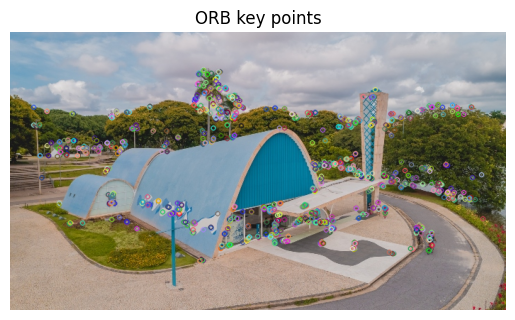

1027


In [3]:
fe = ORBFeatureExtractor('./data/igreja_pampulha.jpg')
fe.run()
fe.plot_key_points('ORB key points')
print(len(fe.kp))

[]


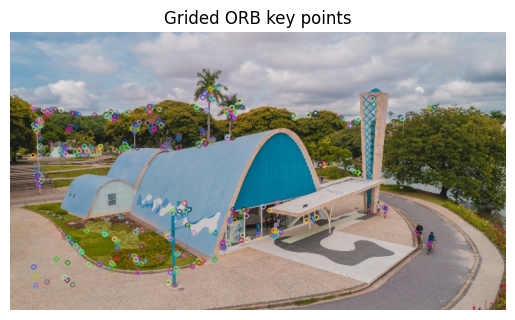

574


In [4]:
fe = GridedORBFeatureExtractor('./data/igreja_pampulha.jpg')
fe.run()
fe.plot_key_points('Grided ORB key points')
print(len(fe.kp))